# Demo: Pipeline with FI-GRL 

Two global parameters need to be defined for this pipeline. The embedding size of figrl's embeddings, and a boolean variable 'add additional data'. The latter is set to True so that the original transaction node data is added to the embeddings before classifications are made by our downstream classifier. It is advised to set this parameter to true, given that transaction features have proven to be very useful in traditional fraud detection. 

In [23]:
# Global parameters:
embedding_size = 64
add_additional_data = True

### 1. Loading the Credit Card Transaction Data

Load numeric, artificially generated transaction data. We transform the index to make sure that they are strictly higher than zero (since FI-GRL is implemented in matlab and matlab graphs can not handle 0 as a node identifier)

In [24]:
import pandas as pd 
import numpy as np

df = pd.read_csv("demo_ccf.csv")
df = df.set_index(df.index+1)

the `train_data` variable stores the data that will be used to construct graphs on which the representation learners can train. 
the `inductive_data` will be used to test the inductive performance of our representation learning algorithms.

In [25]:
cutoff = round(0.6*len(df)) # first 60% of transactions are used for training, last 40% to test inductive capability
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [26]:
print('The distribution of fraud for the train data is:\n', train_data['fraud_label'].value_counts())
print('The distribution of fraud for the inductive data is:\n', inductive_data['fraud_label'].value_counts())

The distribution of fraud for the train data is:
 0    482
1    164
Name: fraud_label, dtype: int64
The distribution of fraud for the inductive data is:
 0    327
1    103
Name: fraud_label, dtype: int64


### 2. Construct the Credit Card Transaction Network

nodes and edges are passed to the GraphConstruction constructor. The FI-GRL framework derives embeddings starting from an adjacency matrix that it constructs using the graph's edgelist. 

In [27]:
from components.GraphConstruction import GraphConstruction

nodes = {"client":train_data.client_node, "merchant":train_data.merchant_node, "transaction":train_data.index}
edges = [zip(train_data.client_node, train_data.index),zip(train_data.merchant_node, train_data.index)]

graph = GraphConstruction(nodes, edges)
figrl_graph = graph.get_edgelist()


## 2.1. Train FI-GRL

FI-GRL, a fast inductive graph representation framework is trained using the aforeconstructed graph. This algorithm is implemented in matlab so we make use of matlab.engine to deploy its native implementation. First, we instantiate the FI-GRL class with the intermediate dimension of the matrix between the input graph and the embedding space, in addition to the size of final dimension (embedding space). FI-GRL's train step returns three matrices: U, which represents the embedding space, sigma and v, which are matrices that will be used in the inductive step to generate embeddings for unseen nodes. 

In [28]:
import matlab.engine
eng = matlab.engine.start_matlab()

#FIGRL hyperparameter
intermediate_dim = 400

#Instantiate FI-GRL
figrl = eng.FIGRL_time(float(intermediate_dim), embedding_size)

#Run train step
figrl_graph = matlab.double(figrl_graph)
U, sigma,v= eng.train_step_figrl(figrl, figrl_graph, nargout = 3)

We transform the embeddings returned by Matlab to a pandas dataframe and select the embeddings of our train nodes. Since FI-GRL assumes homogeneous input graphs, it also generated embeddings for nodes that we are not interested in (client and merchant nodes). We also correct for an index shift of 1. 

In [29]:
figrl_train_emb = pd.DataFrame(U)
figrl_train_emb = figrl_train_emb.set_index(figrl_train_emb.index+1)
figrl_train_emb = figrl_train_emb.loc[train_data.index]

## 2.2. Inductive Step FI-GRL

We want to keep the original indices after concatenating the train and inductive data, because they represent the transaction node ids. We need to concatenate these dataframes in order to easily construct the new graph.

In [30]:
pd.options.mode.chained_assignment = None

train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

A new graph is constructed, which contains the previous nodes in addition to the inductive nodes. FI-GRL will induce embeddings for these unseen nodes using matrices from the train step.

In [31]:
nodes = {"client":inductive_graph_data.client_node, "merchant":inductive_graph_data.merchant_node, "transaction":inductive_graph_data.index}
edges = [zip(inductive_graph_data.client_node, inductive_graph_data.index),zip(inductive_graph_data.merchant_node, inductive_graph_data.index)]

graph = GraphConstruction(nodes, edges)
figrl_graph = graph.get_edgelist()


The inductive step performs computations with the new adjacency matrix and the during training calculated matrices sigma and v. 

In [33]:
edges = matlab.double(graph.get_edgelist())
figrl_inductive_emb = eng.inductive_step_figrl(figrl, edges, sigma, v)

Similar to the train step, we extract the embeddings from the nodes we are interested in (i.e. the transaction nodes).

In [34]:
figrl_inductive_emb = pd.DataFrame(figrl_inductive_emb)
figrl_inductive_emb = figrl_inductive_emb.set_index(figrl_inductive_emb.index+1)
figrl_inductive_emb = figrl_inductive_emb.loc[inductive_data.index]

### 4. Classification: predictions based on inductive embeddings

Select your preferred classification model

In [35]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

If requested, the original transaction features are added to the generated embeddings. If these features are added, a baseline consisting of only these features (without embeddings) is included to analyze the net impact of embeddings on the predictive performance.

In [36]:
train_labels = train_data['fraud_label']

if add_additional_data is True:
    train_emb = pd.merge(figrl_train_emb, train_data.loc[figrl_train_emb.index].drop('fraud_label', axis=1), left_index=True, right_index=True)
    inductive_emb = pd.merge(figrl_inductive_emb, inductive_data.loc[figrl_inductive_emb.index].drop('fraud_label', axis=1), left_index=True, right_index=True)

    baseline_train = train_data.drop('fraud_label', axis=1)
    baseline_inductive = inductive_data.drop('fraud_label', axis=1)

    classifier.fit(baseline_train, train_labels)
    baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(train_emb, train_labels)
predictions = classifier.predict_proba(inductive_emb)


### 5. Evaluation

Given the highly imbalanced nature of our dataset, we evaluate the results based on precision-recall curves. 

Average precision-recall score for  FI-GRL+features  configuration XGBoost: 0.8394341062
Average precision-recall score for  Baseline  configuration XGBoost: 0.8197498524


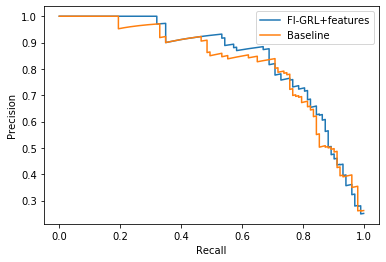

In [37]:
from components.Evaluation import Evaluation
inductive_labels = df.loc[inductive_emb.index]['fraud_label']

figrl_evaluation = Evaluation(predictions, inductive_labels, "FI-GRL+features") 
figrl_evaluation.pr_curve()

if add_additional_data is True:
    baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
    baseline_evaluation.pr_curve()